# The Challenge

### I am a bookworm; I read 3-4 books a month (non-fiction books only) and start 80% of my sentences with "I read that..." 

This is why I decided to scrape goodreads.com for this web-scrapping project (the second of NYC DataScience Academy Bootcamp). Goodreads.com is the world's largest site for readers and book recommendations. Amazon acquired goodreads.com in 2013.

For this project, I was interested in analyzing the common traits of top 500 books on goodreads.com. This would later help predict the success of a book, to some extent. We have not got to machine learning yet... one step at a time!

I only grabbed data for the books under ['best book ever list'](https://www.goodreads.com/list/show/1.Best_Books_Ever). The list includes more than 48,000 books. I **focused on the top 500** for this analysis.

# Importing the modules and files

In [1]:
import csv
import os
import re
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline  
from  matplotlib import style
from matplotlib import rcParams

from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [2]:
bestreads = pd.read_csv('bestreads.csv')

In [3]:
bestreads.head()

,NumberOfPages,Description,BookCoverURL,Author,Reviews,MainGenre,Score,NumberOfReviews,NumberOfRating,Year,Title,TotalScore,AllGenres,Ranking
0,374,"The nation of Panem, formed from a post-apocal...",https://www.goodreads.com/book/photo/2767052-t...,Suzanne Collins,I have got to stop poking fun at this series w...,Young Adult,4.35,154127,4788705,2008,The Hunger Games,"2,717,540","Young Adult,Fiction,Science Fiction,Dystopia,F...",1
1,974,See alternate cover edition,https://www.goodreads.com/book/photo/58696.Dav...,Charles Dickens,DAVID COPPERFIELD: MASTER VILLAINoh you archit...,Classics,3.96,4477,160848,2004,David Copperfield,"63,116","Classics,Fiction,Literature,Historical,Literat...",201
2,1152,A bold English adventurer. An invincible Japan...,https://www.goodreads.com/book/photo/402093.Sh...,James Clavell,"So sorry, I am not worthy of the honor of revi...",Historical,4.36,2980,112868,2009,Shgun,"61,792","Historical,Cultural,Japan,Fiction,Classics,Adv...",206
3,870,Harry Potter is due to start his fifth year at...,https://www.goodreads.com/book/photo/2.Harry_P...,J.K. Rowling,I finished this book with tears in my eyes and...,Fantasy,4.46,27414,1792966,2004,Harry Potter and the Order of the Phoenix,"2,261,901","Fantasy,Childrens,Audiobook",2
4,326,"Nine-year-old Oskar Schell is an inventor, ama...",https://www.goodreads.com/book/photo/4588.Extr...,Jonathan Safran Foer,"well, i'm naturally drawn to those people who ...",Fiction,3.97,20855,311495,2006,Extremely Loud and Incredibly Close,"61,819","Fiction,Contemporary,Historical",205


# Cleaning the data

First, let's make sure all our observations are **unique**.

In [4]:
bestreads.drop_duplicates(inplace = True)

The columns 'Ranking', 'NumberOfPages', 'NumberOfReviews', 'NumberOfRatings' and 'Score' are already of numeric type.
We need to **turn the column 'TotalScore' into a numeric type**.

In [5]:
bestreads['TotalScore'] = bestreads['TotalScore'].str.replace(',', '')
bestreads['TotalScore'] = bestreads['TotalScore'].apply(lambda x: int(x))

In our analysis, we will differentiate the books by their ranking. We'll create categories such as 'Top 100', 'Top 100 - 200', etc.. In order to do that, we will **add a new column 'RankingCat'**.

In [6]:
bestreads['Ranking'] = bestreads['Ranking'].apply(lambda x: int(x)) # convert to integer

def rankingcat(row):
	if (row['Ranking'] >= 1) and (row['Ranking'] <=100):
		return 'Top 100'
	elif (row['Ranking'] > 100) and (row['Ranking'] <=200):
		return 'Top 100 - 200'
	elif (row['Ranking'] > 200) and (row['Ranking'] <=300):
		return 'Top 200 - 300'
	elif (row['Ranking'] > 300) and (row['Ranking'] <=400):
		return 'Top 300 - 400'
	else:
		return 'Top 400 - 500'

bestreads['RankingCat'] = bestreads.apply(lambda x: rankingcat(x), axis = 1)

## The 'Reviews' column

The 'Reviews' column requires a little bit more cleaning. We will have to do some **stemming and lemmatization**. But first lets' remove any puntuation and replace multiple white spaces with one.

In [7]:
bestreads['Reviews'] = [re.sub( '[.:\',\-;"()?]', " ", reviews).strip() for reviews in bestreads['Reviews']]
bestreads['Reviews'] = [re.sub( '\s+', " ", reviews ).strip() for reviews in bestreads['Reviews']]
bestreads['Reviews'] = [reviews.lower() for reviews in bestreads['Reviews']]

We remove the words that don't matter from the Reviews column (e.g. I, and, the, this, etc.)

In [8]:
from nltk.corpus import stopwords
from nltk.tag import pos_tag

stop_words = set(stopwords.words("english"))
bestreads['Reviews'] = bestreads['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

We remove proper noun from the Reviews column and remove the commas.

In [9]:
# bestreads['Reviews'] = bestreads['Reviews'].apply(lambda x: [word for word,pos in pos_tag(x.split()) if pos != 'NNP'])

In [10]:
# bestreads['Reviews'].head()

We also remove any words with 1 or 2 letters.

In [11]:
shortword = re.compile(r'\W*\b\w{1,2}\b')
bestreads['Reviews'] = [shortword.sub('', word) for word in bestreads['Reviews']]

# 1- A few things to consider before you write your next book...

Let's do a quick Exploratory Data Analysis before moving on to the more serious graphs... Below are the 3 mains questions:

+ What is the distribution of the top books by genre?



### Distribution of Top 500 books by year of publication

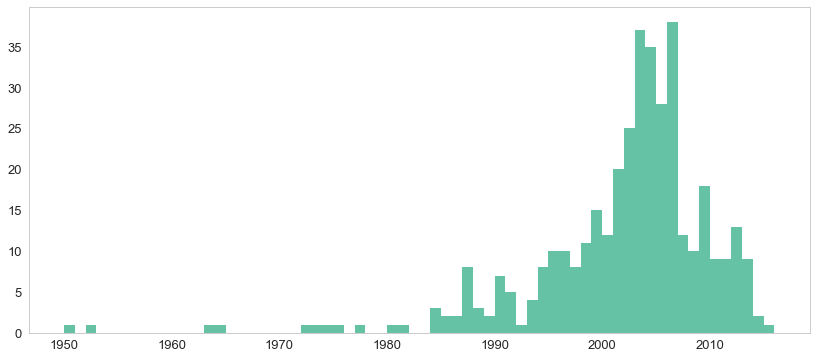

In [12]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
with sns.color_palette("Set2", 5), sns.plotting_context("notebook",font_scale=1.3):
    year_df = (bestreads['Year'])
    year_df.plot.hist(bins = max(bestreads['Year']) - min(bestreads['Year']), figsize=(14, 6))
    plt.ylabel('')
#     plt.title('Number of books in top 500 list by year of publication', fontsize=16)

In [13]:
# genre_year_df = sns.FacetGrid(bestreads, col="MainGenre", hue="MainGenre", col_wrap=5)
# genre_year_df.map(plt.hist, "Year")

In [14]:
# # histogram with density plot
# with sns.color_palette("Set2", 5):
#     sns.distplot(bestreads['Year'], 
#                  bins = max(bestreads['Year']) - min(bestreads['Year']))
#     plt.title('Number of books in top 500 list by year of publication', fontsize=16)

### Distribution of Top 500 books by genre

A book may have multiple genres. Right now, the genres are all in one column (separated by a tab) so we will need to create a dataframe and have as many rows as there are genres for each book.

We'll have to separate the genres first, then create a Python dictionary from the `dataframe` function and convert it back to a `dataframe`.

In [35]:
df_genre = bestreads.copy()
df_genre.AllGenres = df_genre.AllGenres.apply(lambda x: x.split(','))

In [36]:
df_genre.iloc[0].to_dict()
df_genre = pd.concat([pd.DataFrame(df_genre.iloc[i].to_dict()) for i in range(len(df_genre))])

In [37]:
df_genre.head()

,AllGenres,Author,BookCoverURL,Description,MainGenre,NumberOfPages,NumberOfRating,NumberOfReviews,Ranking,RankingCat,Reviews,Score,Title,TotalScore,Year
0,Young Adult,Suzanne Collins,https://www.goodreads.com/book/photo/2767052-t...,"The nation of Panem, formed from a post-apocal...",Young Adult,374,4788705,154127,1,Top 100,got stop poking fun series memes someone take ...,4.35,The Hunger Games,2717540,2008
1,Fiction,Suzanne Collins,https://www.goodreads.com/book/photo/2767052-t...,"The nation of Panem, formed from a post-apocal...",Young Adult,374,4788705,154127,1,Top 100,got stop poking fun series memes someone take ...,4.35,The Hunger Games,2717540,2008
2,Science Fiction,Suzanne Collins,https://www.goodreads.com/book/photo/2767052-t...,"The nation of Panem, formed from a post-apocal...",Young Adult,374,4788705,154127,1,Top 100,got stop poking fun series memes someone take ...,4.35,The Hunger Games,2717540,2008
3,Dystopia,Suzanne Collins,https://www.goodreads.com/book/photo/2767052-t...,"The nation of Panem, formed from a post-apocal...",Young Adult,374,4788705,154127,1,Top 100,got stop poking fun series memes someone take ...,4.35,The Hunger Games,2717540,2008
4,Fantasy,Suzanne Collins,https://www.goodreads.com/book/photo/2767052-t...,"The nation of Panem, formed from a post-apocal...",Young Adult,374,4788705,154127,1,Top 100,got stop poking fun series memes someone take ...,4.35,The Hunger Games,2717540,2008


Before doing any plots involving genres, we'll check how many of them we have and select the ones that constitute 80% of the dataset.

In [34]:
len(set(df_genre['AllGenres'])) #there are 193 genres. 

193

In [41]:
from collections import Counter
counter = Counter(df_genre['AllGenres']) # create dictionary with list of each genre and # of books per genre
counter_df = pd.DataFrame(counter.items(), columns = ['Genre', 'Count']) # turn dictionary into dataframe
counter_df = counter_df.sort_values('Count', ascending = False)

# replace name of Genre to "Other" when Genre has less than 75 books associated with it
counter_df['Genre'][counter_df['Count']<75] = 'Other'
    
counter_df.head(15)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Genre,Count
39,Fiction,306
14,Classics,243
187,Fantasy,227
97,Young Adult,154
111,Literature,150
81,Historical,118
181,Childrens,96
58,Romance,95
20,Science Fiction,79
113,Other,66


In [56]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# fig = {
#     'data': [{'labels': ['Residential', 'Non-Residential', 'Utility'],
#               'values': [19, 26, 55],
#               'type': 'pie'}],
#     'layout': {'title': 'Forcasted 2014 U.S. PV Installations by Market Segment'}
#      }

# py.iplot(fig)


# df_pie = go.Pie(labels=counter_df['Genre'], values=counter_df['Count'])

# py.iplot([df_pie])

In [96]:
data = [
    go.Area(
    r=counter_df['Count'],
    t=counter_df['Genre'],
    name='Number of Books',
    marker=dict(
        color='rgb(102,166,30)'
    ))
        ] 

axis_template = dict(
    showgrid= False,
    zeroline=False,
    nticks = 20,
    showline = False,
    showticklabels=False
    )

layout = go.Layout(
    title='Distribution of Top 500 books by genre',
    font=dict(
        size=14,
        color = '#000'
    ),
    showlegend = False,
    legend=dict(
        font=dict(
            size=10
        )
    ),
    angularaxis=dict(
        tickcolor='#CCC',
        showline=False,
    ),
    xaxis = axis_template,
    orientation= 90
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

PlotlyRequestError: Hey there! You've hit one of our API request limits. 

To get unlimited API calls(10,000/day), please upgrade to a paid plan. 

UPGRADE HERE: https://goo.gl/i7glmM 

Thanks for using Plotly! Happy Plotting!

### Distribution of Top 500 books by number of pages

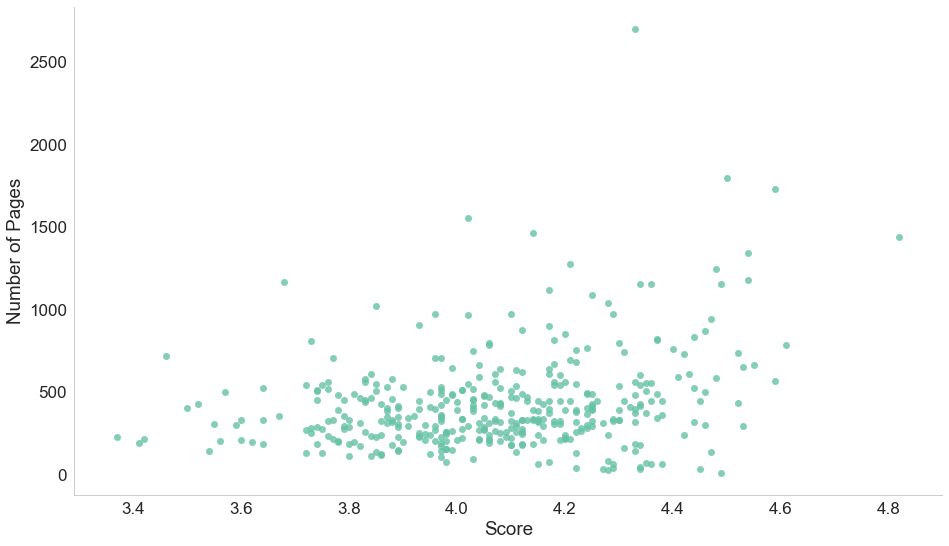

In [88]:
with sns.color_palette("Set2", 5), sns.plotting_context("notebook",font_scale=1.7):
    sns.lmplot("Score", "NumberOfPages", bestreads, palette="Set2", fit_reg=False, size=8, aspect = 1.7)
    plt.ylabel('Number of Pages')
    plt.xlabel('Score')

In [13]:
from bokeh.charts import Donut


In [30]:
from itertools import *
from nltk.tokenize import wordpunct_tokenize 
from afinn import Afinn
afinn = Afinn()

filtered_df = bestreads[['RankingCat','Reviews']]
filtered_df.count()

RankingCat    388
Reviews       388
dtype: int64

In [31]:
stop_words = set(stopwords.words('english'))

unigrams = []
afinn_value = []
ranking_category = []
for ind, review in islice(filtered_df.iterrows(),388):
    unigrams = ( [i.lower() for i in wordpunct_tokenize(review['Reviews']) if i.lower() not in stop_words])
    afinn_value.append(np.mean(list(map(lambda x: afinn.score(str(x.encode('utf-8'))), unigrams))))
    ranking_category.append(review['RankingCat'])

In [32]:
score_boxplot = pd.DataFrame()
score_boxplot['ranking_category'] = ranking_category
score_boxplot['senti_value'] = afinn_value
score_boxplot['ranking_category'].min()

'Top 100'

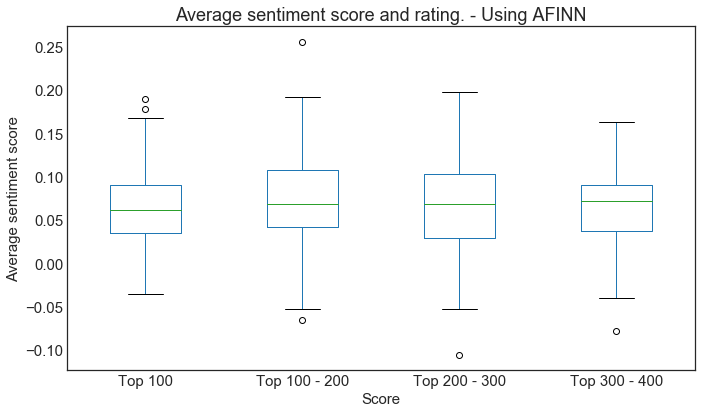

In [36]:
rcParams.update({'font.size': 15})
plt.style.use('seaborn-white')
ax = score_boxplot.boxplot(by=['ranking_category'], figsize=(10,6))
ax.get_figure().suptitle("")
ax.set_title('Average sentiment score and rating. - Using AFINN')
ax.set_xlabel('Score')
ax.set_ylabel('Average sentiment score')
ax.grid(False)

In [ ]:
# create a new plot
p = figure(
   tools="pan,box_zoom,reset,save",
   y_axis_type="log", y_range=[0.001, 10**11], title="log axis example",
   x_axis_label='sections', y_axis_label='particles'
)

# add some renderers
p.line(x, x, legend="y=x")
p.circle(x, x, legend="y=x", fill_color="white", size=8)
p.line(x, y0, legend="y=x^2", line_width=3)
p.line(x, y1, legend="y=10^x", line_color="red")
p.circle(x, y1, legend="y=10^x", fill_color="red", line_color="red", size=6)
p.line(x, y2, legend="y=10^x^2", line_color="orange", line_dash="4 4")

# show the results
show(p)